In [1]:
import random
from tqdm import tqdm

In [2]:
# set the random seed 
random.seed(42)

In [3]:
class Container:
    def __init__(self, multiplier, inhabitants, ID):
        self.multiplier = multiplier
        self.inhabitants = inhabitants
        self.ID = ID

In [4]:
class Player:
    def __init__(self, ID, preference):
        self.ID = ID
        self.preference = preference
        self.second_prob = 1
        self.cur_rewards = None
        self.best_rewards = None
        self.first_choice = None
        self.second_choice = None

In [5]:
# set the parameters
base = 10000
cost = 50000
num_agents = 3000
num_rounds = 20000
discount_factor = 0.99

# container margins
margins = [
    (10, 1),
    (80, 6),
    (37, 3),
    (17, 1),
    (90, 10),
    (31, 2),
    (50, 4),
    (20, 2),
    (73, 4),
    (89, 8),
]

# equal preference
# pure margin preference
# 10% margin preference
# random preference
equal_preference = {}
pure_preference = {}
decimal_preference = {}

for index, margin in enumerate(margins):
    equal_preference[index] = 1
    pure_preference[index] = margin[0]/margin[1]
    decimal_preference[index] = margin[0]/(margin[1]+10)

In [6]:
# get some insights of the margins
for margin in margins:
    print(f'pure margin: {margin[0]/margin[1]}')
    print(f'1%: {margin[0]/(margin[1]+1)}')
    print(f'10%: {margin[0]/(margin[1]+10)}')
    print(f'50%: {margin[0]/(margin[1]+50)}')
    print(f'100%: {margin[0]/(margin[1]+100)}\n')

pure margin: 10.0
1%: 5.0
10%: 0.9090909090909091
50%: 0.19607843137254902
100%: 0.09900990099009901

pure margin: 13.333333333333334
1%: 11.428571428571429
10%: 5.0
50%: 1.4285714285714286
100%: 0.7547169811320755

pure margin: 12.333333333333334
1%: 9.25
10%: 2.8461538461538463
50%: 0.6981132075471698
100%: 0.3592233009708738

pure margin: 17.0
1%: 8.5
10%: 1.5454545454545454
50%: 0.3333333333333333
100%: 0.16831683168316833

pure margin: 9.0
1%: 8.181818181818182
10%: 4.5
50%: 1.5
100%: 0.8181818181818182

pure margin: 15.5
1%: 10.333333333333334
10%: 2.5833333333333335
50%: 0.5961538461538461
100%: 0.30392156862745096

pure margin: 12.5
1%: 10.0
10%: 3.5714285714285716
50%: 0.9259259259259259
100%: 0.4807692307692308

pure margin: 10.0
1%: 6.666666666666667
10%: 1.6666666666666667
50%: 0.38461538461538464
100%: 0.19607843137254902

pure margin: 18.25
1%: 14.6
10%: 5.214285714285714
50%: 1.3518518518518519
100%: 0.7019230769230769

pure margin: 11.125
1%: 9.88888888888889
10%: 4.944

In [7]:
# create the containers
containers = {}
for index, margin in enumerate(margins):
    containers[index] = Container(margin[0], margin[1], index)

In [8]:
# Pareto 2-8 rules

In [9]:
# create the players
players = []
for i in range(num_agents):
    num = random.random()
    if 0.25 < num <= 0.5:
        players.append(Player(i, equal_preference))
    if 0.5 < num <= 0.75:
        players.append(Player(i, pure_preference))
    if num > 0.75:
        players.append(Player(i, decimal_preference))
    if num <= 0.25:
        random_preference = {}
        for j in range(len(margins)):
            random_preference[j] = random.random()
        players.append(Player(i, random_preference))

    
    # for j in range(len(margins)):
    #     if j == 8:
    #         random_preference[j] = random.random() + 1
    #     if j == 3:
    #         random_preference[j] = random.random() + 0.5
    #     if j == 6:
    #         random_preference[j] = random.random() + 0.3
    #     else:
    #         random_preference[j] = random.random()
    
    # players.append(Player(i, random_preference))
    # if 0.25 < num <= 0.5:
    #     players.append(Player(i, equal_preference))
    # if 0.5 < num <= 0.75:
    #     players.append(Player(i, pure_preference))
    # if num > 0.75:
    #     players.append(Player(i, decimal_preference))
    

In [10]:
# begin the game
for _ in tqdm(range(num_rounds)):

    # container percentage
    # at the beginning of each run, empty and renew the counts
    counts = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0,
        6: 0,
        7: 0,
        8: 0,
        9: 0,
    }
    
    # iterate the players
    for player in players:
        
        # extract the preference
        weights = []
        for i in range(len(player.preference)):
            weights.append(player.preference[i])

        # select the first container based on the weights + update counts
        first_container = random.choices(containers, weights=weights, k=1)[0]
        player.first_choice = first_container
        counts[first_container.ID] += 1

        # check if to choose the second container + update counts
        if random.random() < player.second_prob:
            second_container = random.choices(containers, weights=weights, k=1)[0]
            if second_container.ID != first_container.ID:
                player.second_choice = second_container
                counts[second_container.ID] += 1
        # do not keep the second_choice any more
        else:
            player.second_choice = None
        
    # normalize the counts first
    counts_list = []
    for i in range(len(counts)):
        counts_list.append(counts[i])
    sum_counts = sum(counts_list)
    percentage = [(count / sum_counts) for count in counts_list]

    # calculate and udpate the rewards of each player
    for player in players:
        # the first container
        multiplier = player.first_choice.multiplier
        inhabitants = player.first_choice.inhabitants
        percent = percentage[player.first_choice.ID] * 100
        player.cur_rewards = base * multiplier / (inhabitants + percent)

        if player.second_choice is not None:
            # calcualte the second container rewards
            multiplier_2 = player.second_choice.multiplier
            inhabitants_2 = player.second_choice.inhabitants
            percent_2 = percentage[player.second_choice.ID] * 100
            player.cur_rewards += base * multiplier_2 / (inhabitants_2 + percent_2) - cost

            # if choosing the second one gives negative PnL, then discount the prob
            # in this step, we only discount the prob to do the second choice, not the container preference
            # since maybe choose the second as first can give more positive PnL
            if base * multiplier_2 / (inhabitants_2 + percent_2) - cost <= 0:
                player.second_prob *= discount_factor
            else:
                player.second_prob *= 1/discount_factor

        # --------------------------optimization-------------------------------------------------
        # now have the cur_rewards, compare with the best rewards
        # if this is the first round of game, only assign the current rewards to the best rewards
        if player.best_rewards is None:
            player.best_rewards = player.cur_rewards
        else:
            # if the current choice is worse, then we discount the preference of that container
            # if the current choice is better, we do nothing at all, to avoid sticking in "only this" trap
            if player.cur_rewards < player.best_rewards:
                player.preference[player.first_choice.ID] *= discount_factor

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:25<00:00, 97.11it/s]


In [11]:
# after the game, find hte best rewards agent and see the parameters
rank_players = sorted(players, key=lambda player: player.cur_rewards, reverse=True)

In [12]:
print(rank_players[0].cur_rewards)
print(rank_players[0].first_choice.ID)
if rank_players[0].second_choice is None:
    print("None")
else: 
    print(rank_players[0].second_choice.ID)
print(rank_players[0].second_prob)
print(rank_players[0].preference)
print("\n")
print(rank_players[len(rank_players) - 1].cur_rewards)
print(rank_players[len(rank_players) - 1].first_choice.ID)
if rank_players[len(rank_players) - 1].second_choice is None:
    print("None")
else: 
    print(rank_players[len(rank_players) - 1].second_choice.ID)
print(rank_players[len(rank_players) - 1].second_prob)
print(rank_players[len(rank_players) - 1].preference)

47022.71949341092
8
None
0.005428326933086734
{0: 0.029864191177541282, 1: 0.3298963136648855, 2: 0.0873183704818634, 3: 0.09197631203100314, 4: 0.7362571821096542, 5: 0.49379170946302364, 6: 0.6153083586742819, 7: 0.5237507839176447, 8: 0.5048481036557847, 9: 0.8889580341933749}


-3735.7763227110263
5
7
0.005374043663755866
{0: 2.4e-322, 1: 2.4e-322, 2: 2.4e-322, 3: 2.4e-322, 4: 2.4e-322, 5: 2.4e-322, 6: 2.4e-322, 7: 2.4e-322, 8: 2.4e-322, 9: 2.4e-322}


In [29]:
# for now we've trained 2000 rational agents, let's get some insights
# now let's play with the 2000 agents
# create our agent

# set common parameters of our agents
my_ID = 3001
interactions = 1000

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:58<00:00, 84.11it/s]


[10605.278763518314, 46266.1256987795, 29148.59683944537, 17130.593947157646, 43858.32356915392, 26924.09536581115, 35831.77083416057, 18176.52713327525, 47154.04294985931, 46171.961338279]


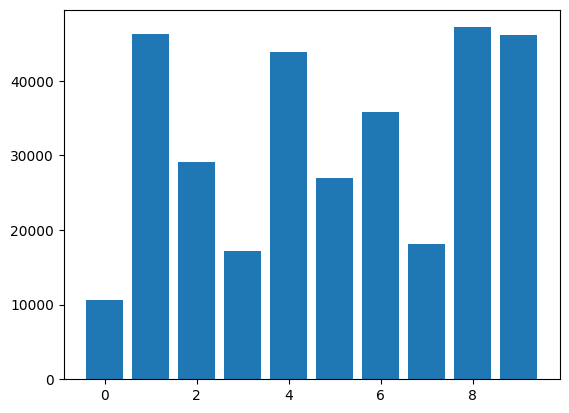

In [30]:
# 1. the first strategy is to always choose the first container, no second container
# create the list to contain the mean PnL
mean_PnL = []

for i in range(len(containers)):

    # create the list to contain every iteration cur_rewards
    rewards = []

    # create the strategy preference
    preference = {}
    for j in range(len(containers)):
        if j == i:
            preference[j] = 1
        else:
            preference[j] = 0

    # create our agent, and aad to the players (the last one)
    agent = Player(my_ID, preference)
    agent.second_prob = 0

    # pop the last agent if there is any
    if len(players) > num_agents:
        players.pop()
    players.append(agent)

    # start the game
    for _ in tqdm(range(interactions)):
        # for each player, let him/her choose the containers based on their preference

        # container percentage
        # at the beginning of each run, empty and renew the counts
        counts = {
            0: 0,
            1: 0,
            2: 0,
            3: 0,
            4: 0,
            5: 0,
            6: 0,
            7: 0,
            8: 0,
            9: 0,
        }
        
        # iterate the players
        for player in players:
            
            # extract the preference
            weights = []
            for i in range(len(player.preference)):
                weights.append(player.preference[i])
    
            # select the first container based on the weights + update counts
            first_container = random.choices(containers, weights=weights, k=1)[0]
            player.first_choice = first_container
            counts[first_container.ID] += 1
    
            # check if to choose the second container + update counts
            if random.random() < player.second_prob:
                second_container = random.choices(containers, weights=weights, k=1)[0]
                if second_container.ID != first_container.ID:
                    player.second_choice = second_container
                    counts[second_container.ID] += 1
            # do not keep the second_choice any more
            else:
                player.second_choice = None

        # normalize the counts first
        counts_list = []
        for i in range(len(counts)):
            counts_list.append(counts[i])
        sum_counts = sum(counts_list)
        percentage = [(count / sum_counts) for count in counts_list]

        # calculate all parameters of our agent
        # the first container
        our_agent = players[-1]

        # check if this is our agent
        if our_agent.ID != my_ID:
            raise ValueError('This is not our agent')
        multiplier = our_agent.first_choice.multiplier
        inhabitants = our_agent.first_choice.inhabitants
        percent = percentage[our_agent.first_choice.ID] * 100
        our_agent.cur_rewards = base * multiplier / (inhabitants + percent)

        # check whethere the second_choice is None
        if our_agent.second_choice is not None:
            raise ValueError('There should not be any second choice')

        #----------------------------------------------------------------------------------------------------
        # our_agent.second_choice = containers[9]
        # # calcualte the second container rewards
        # multiplier_2 = our_agent.second_choice.multiplier
        # inhabitants_2 = our_agent.second_choice.inhabitants
        # percent_2 = percentage[our_agent.second_choice.ID] * 100
        # our_agent.cur_rewards += base * multiplier_2 / (inhabitants_2 + percent_2) - cost

        #------------------------------------------------------------------------------------------------------

        # add this iteration rewards
        rewards.append(our_agent.cur_rewards)

    # calculate and append the mean PnL for each container choice
    if len(rewards) != interactions:
        raise ValueError('Not the same length')
    mean_PnL.append(sum(rewards)/len(rewards))
        
import matplotlib.pyplot as plt

plt.bar(range(10), mean_PnL)
print(mean_PnL)
        